# RBC Case

## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, auc
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, f1_score
from sklearn.metrics import log_loss, confusion_matrix, recall_score, precision_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv("Dataset.csv")

In [3]:
df.head()

,Client ID Number,Campaign Response,Customer_Age,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Did Not Respond,45,M,High School,Married,$60K - $80K,Rewards Basic,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Did Not Respond,49,F,Graduate,Single,Less than $40K,Rewards Basic,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Did Not Respond,51,M,Graduate,Married,$80K - $120K,Rewards Basic,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Did Not Respond,40,F,High School,Unknown,Less than $40K,Rewards Basic,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Did Not Respond,40,M,NaN,Married,$60K - $80K,Rewards Basic,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Client ID Number          10127 non-null  int64  
 1   Campaign Response         10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Education_Level           8640 non-null   object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [5]:
df.describe()

,Client ID Number,Customer_Age,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


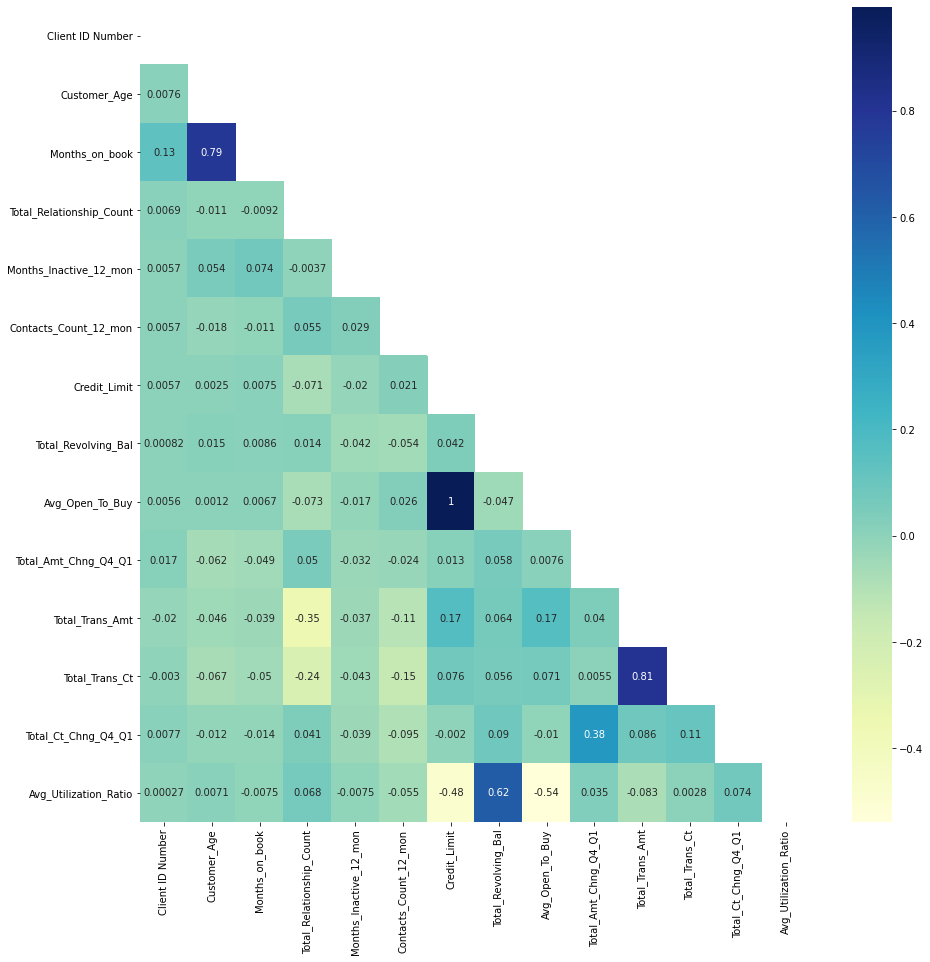

In [6]:
corr = df.corr()

import matplotlib.pyplot as plt
import seaborn as sns
 
plt.figure(figsize=(15, 15))
matrix = np.triu(corr)
sns.heatmap(corr,cmap='YlGnBu', annot=True, mask = matrix)

In [7]:
df['Campaign Response'].value_counts()

Did Not Respond    8500
Did Respond        1627
Name: Campaign Response, dtype: int64

In [8]:
df["Education_Level"] = df["Education_Level"].fillna(value='Unknown')

## Data Prep

In [9]:
y = df['Campaign Response']
y = y.replace(['Did Not Respond', 'Did Respond '], [0, 1])
X = df.drop(['Client ID Number', 'Campaign Response'], axis=1)
X_dum = pd.get_dummies(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, stratify = df[['Campaign Response','Card_Category']], random_state=42)

X_train.reset_index(drop=True)
y_train.reset_index(drop=True)
X_test.reset_index(drop=True)
y_test.reset_index(drop=True)

0       0
1       0
2       0
3       0
4       0
       ..
2021    1
2022    0
2023    1
2024    0
2025    0
Name: Campaign Response, Length: 2026, dtype: int64

In [11]:
# Model Performance Metrics Helper

from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, auc
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, f1_score
from sklearn.metrics import log_loss, confusion_matrix, recall_score, precision_score

def cv_score(y_test, y_pred, y_prob, sprint):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy       = accuracy_score(y_test, y_pred)
    f1             = f1_score(y_test, y_pred)
    f1n            = f1_score(y_test, y_pred, pos_label=0)
    macrof1        = f1_score(y_test, y_pred, average='macro')
    recall         = recall_score(y_test, y_pred)
    precision      = precision_score(y_test, y_pred)
    recall_n       = recall_score(y_test, y_pred, pos_label=0)
    precision_n    = precision_score(y_test, y_pred, pos_label=0)
    roc_auc        = roc_auc_score(y_test, y_prob)
    
    df = pd.DataFrame({"Sprint"    : [sprint],
                       "Neg"       : [tn + fn],
                       "TN"  : [tn],
                       "FN" : [fn],
                       "Pos"       : [tp + fp],
                       "TP"        : [tp],
                       "FP"        : [fp],
                       "Accuracy"  : [accuracy],
                       "Recall"    : [recall],
                       "Precision" : [precision],
                       "Recall 0"  : [recall_n],
                       "Precision 0":[precision_n],
                       "F1"        : [f1],
                       "F1 0"      : [f1n],
                       "Macro F1"  : [macrof1],
                       "AUC"       : [roc_auc],
                      })
    
    return df

score_list = ["Sprint", "Neg", "TN", "FN", "Pos", "TP", "FP",
              "Accuracy", "Recall", "Precision", "Recall 0", "Precision 0",
              "F1", "F1 0", "Macro F1", "AUC"]

In [12]:
# Sampling Helper

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

def sampling_evaluate(X_train, X_test, y_train, y_test):
    
    evals = list()
    resampe_methods = ['Base', 'Class Weights', RandomOverSampler, SMOTE, ADASYN, RandomUnderSampler]
    names = ['Base', 'Class Weights', 'Over Sample', 'Over SMOTE', 'Over ADASYN', 'Under Sample']
    
    for i in range(0,6):
        method = resampe_methods[i]
        name = names[i]
        cw = None
        X_resampled, y_resampled = X_train, y_train

        if method =='Class Weights':
            cw = 'balanced'
        elif method == 'Base':
            pass
        else:
            resample_method = method
            X_resampled, y_resampled = resample_method(random_state=0).fit_resample(X_train, y_train)

        clf = DecisionTreeClassifier(random_state=0, class_weight=cw)
        #clf = LogisticRegression(max_iter=1000, class_weight=cw, random_state=0)

        clf.fit(X_resampled, y_resampled)
        y_pred = clf.predict(X_test)
        y_prob = pd.DataFrame(clf.predict_proba(X_test))[1]

        df = cv_score(y_test, y_pred, y_prob, 0)
        df = df.drop("Sprint", axis=1)
        df_temp = pd.DataFrame([name], columns=['Method'])
        df = df_temp.merge(df, left_index=True, right_index=True)
        evals.append(df)
    
    evals_all = pd.concat([m for m in evals], axis = 0).reset_index()

    evals_all = evals_all.drop(columns = "index",axis =1)
    evals_all = evals_all.sort_values(by=['Macro F1'], ascending=False)
    
    return evals_all

In [13]:
sampling_methods = sampling_evaluate(X_train, X_test, y_train, y_test)
sampling_methods

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

,Method,Neg,TN,FN,Pos,TP,FP,Accuracy,Recall,Precision,Recall 0,Precision 0,F1,F1 0,Macro F1,AUC
0,Base,1696,1637,59,330,266,64,0.939289,0.818462,0.806061,0.962375,0.965212,0.812214,0.963792,0.888003,0.890418
2,Over Sample,1699,1638,61,327,264,63,0.938796,0.812308,0.807339,0.962963,0.964097,0.809816,0.963529,0.886673,0.887635
3,Over SMOTE,1662,1614,48,364,277,87,0.933366,0.852308,0.760989,0.948854,0.971119,0.804064,0.959857,0.881961,0.900581
1,Class Weights,1700,1636,64,326,261,65,0.936328,0.803077,0.800613,0.961787,0.962353,0.801843,0.962070,0.881957,0.882432
4,Over ADASYN,1666,1605,61,360,264,96,0.922507,0.812308,0.733333,0.943563,0.963385,0.770803,0.953371,0.862087,0.877935
5,Under Sample,1590,1558,32,436,293,143,0.913623,0.901538,0.672018,0.915932,0.979874,0.770039,0.946825,0.858432,0.908735


## Modelling

In [14]:
skf = StratifiedKFold(n_splits=5)

In [15]:
# Cross Validation Helper

def train_cv(X, y, clf, cvsplit, resampling=None):

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(10, 8))

    dt_score = pd.DataFrame(columns=score_list)
    
    y = y.to_numpy()

    # Cross Validation Sprints
    i = 0
    for train_index, test_index in cvsplit.split(X, y):
        i = i+1

        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        print("\n===========================================================")
        print("Split {}".format(i))
        #print(train_index)
        #print(test_index)
        print("X_train shape: {}".format(X_train.shape))
        print("X_test shape: {}".format(X_test.shape))

        if resampling != None:
            X_resampled, y_resampled = resampling(random_state=0).fit_resample(X_train, y_train)
        else:
            X_resampled = X_train
            y_resampled = y_train
        
        clf = clf.fit(X_resampled, y_resampled)

        y_pred = clf.predict(X_test)
        y_prob = pd.DataFrame(clf.predict_proba(X_test))[1]

        # ROC Curves
        viz = plot_roc_curve(clf, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        # Performance Metrics
        print("\nF1 Score  = {:.2f}".format(f1_score(y_test, y_pred, average="macro")))
        print("Accuracy   = {:.2f}".format(accuracy_score(y_test, y_pred)))
        print("Kappa      = {:.2f}".format(cohen_kappa_score(y_test, y_pred)))
        print("Log Loss   = {:.2f}".format(log_loss(y_test, y_pred)))
        print("\nConfusion Matrix:")
        unique_label = np.unique(y_pred)
        cmtx = pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=unique_label), 
        index=['true:{:}'.format(x) for x in unique_label], 
        columns=['pred:{:}'.format(x) for x in unique_label])
        print(cmtx)
        dt_score = dt_score.append(cv_score(y_test, y_pred, y_prob, i))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred)) 

    # Plot ROCs
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="{} ROC Curve".format(str(clf).partition("(")[0]))
    ax.legend(loc="lower right")
    plt.show()
    
    # Results
    tempdt = dt_score.mean()
    tempdt["Sprint"] = 'Mean'
    dt_score = dt_score.append(tempdt, ignore_index=True)
    
    return dt_score

In [16]:
result = []

<b>Linear Regression</b>


Split 1
X_train shape: (6480, 35)
X_test shape: (1621, 35)

F1 Score  = 0.77
Accuracy   = 0.89
Kappa      = 0.55
Log Loss   = 3.69

Confusion Matrix:
        pred:0  pred:1
true:0    1316      44
true:1     129     132

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1360
           1       0.75      0.51      0.60       261

    accuracy                           0.89      1621
   macro avg       0.83      0.74      0.77      1621
weighted avg       0.88      0.89      0.88      1621


Split 2
X_train shape: (6481, 35)
X_test shape: (1620, 35)

F1 Score  = 0.76
Accuracy   = 0.89
Kappa      = 0.52
Log Loss   = 3.88

Confusion Matrix:
        pred:0  pred:1
true:0    1312      48
true:1     134     126

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1360
           1       0.72      0.48      0.58       260

    accuracy         

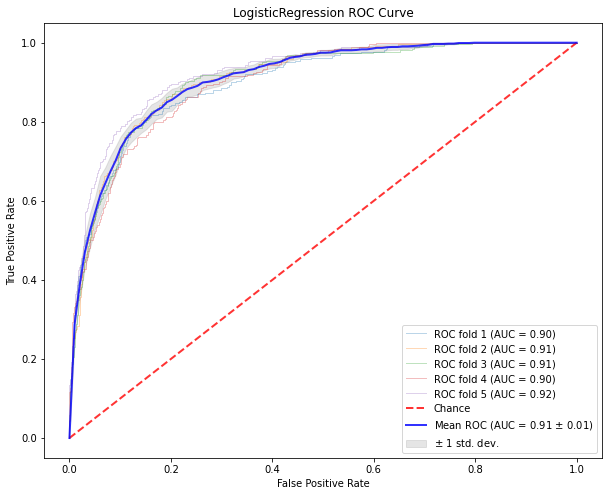

In [17]:
# Cross validation

lr = LogisticRegression(max_iter=2000, random_state=42)

cv_lr = train_cv(X_train, y_train, lr, skf, None)

In [18]:
# LR model

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
y_pred = lr.predict(X_test)
y_prob = pd.DataFrame(lr.predict_proba(X_test))[1]

In [20]:
y_train.count()

8101

In [21]:
y_test.count()

2026

In [22]:
result.append(cv_score(y_test, y_pred, y_prob, 'Linear Regression'))

<b>Decision Tree</b>

In [23]:
# Hyperparameter Tuning

params = {"criterion":      ["gini", "entropy"],
          "max_depth":      np.arange(2, 6),
          "max_features":   np.arange(1, 20),
          "max_leaf_nodes": np.arange(6, 10),
         }

clf = DecisionTreeClassifier(random_state=42)
gridsearch = GridSearchCV(clf, param_grid=params, 
                          cv=5, scoring='f1_macro', return_train_score=True)

gridsearch.fit(X_train, y_train)

y_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred))
print(gridsearch.best_estimator_)

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1701
           1       0.68      0.78      0.73       325

    accuracy                           0.91      2026
   macro avg       0.82      0.85      0.84      2026
weighted avg       0.91      0.91      0.91      2026

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=19, max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')



Split 1
X_train shape: (6480, 35)
X_test shape: (1621, 35)

F1 Score  = 0.81
Accuracy   = 0.91
Kappa      = 0.61
Log Loss   = 3.17

Confusion Matrix:
        pred:0  pred:1
true:0    1324      36
true:1     113     148

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1360
           1       0.80      0.57      0.67       261

    accuracy                           0.91      1621
   macro avg       0.86      0.77      0.81      1621
weighted avg       0.90      0.91      0.90      1621


Split 2
X_train shape: (6481, 35)
X_test shape: (1620, 35)

F1 Score  = 0.81
Accuracy   = 0.91
Kappa      = 0.61
Log Loss   = 3.24

Confusion Matrix:
        pred:0  pred:1
true:0    1316      44
true:1     108     152

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1360
           1       0.78      0.58      0.67       260

    accuracy         

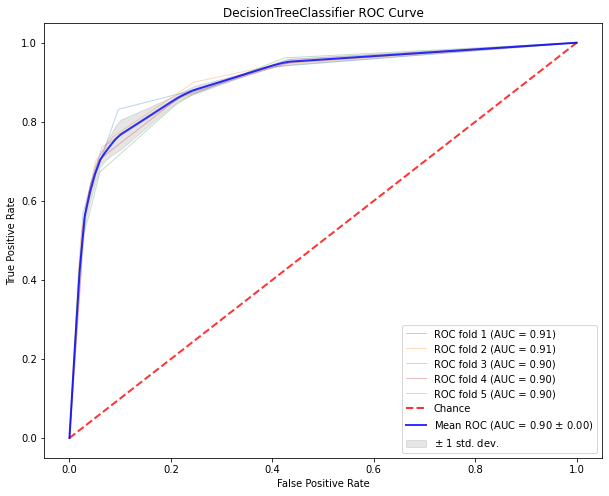

In [24]:
# Cross validation

dt = DecisionTreeClassifier(max_depth=5, max_features=19,
                            max_leaf_nodes=8, random_state=42)

cv_dt = train_cv(X_train, y_train, dt, skf, None)

In [25]:
# DT model

dt = DecisionTreeClassifier(max_depth=5, max_features=19,
                            max_leaf_nodes=8, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=19, max_leaf_nodes=8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [26]:
y_pred = dt.predict(X_test)
y_prob = pd.DataFrame(dt.predict_proba(X_test))[1]

In [27]:
result.append(cv_score(y_test, y_pred, y_prob, 'Decision Tree'))

In [28]:
dt.feature_importances_


array([0.        , 0.        , 0.11810178, 0.        , 0.        ,
       0.        , 0.33649551, 0.        , 0.0365688 , 0.08801155,
       0.37424184, 0.04658052, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [29]:
for importance, name in sorted(zip(dt.feature_importances_, X_train.columns),reverse=True)[:6]:
    print (name, importance)

Total_Trans_Ct 0.374241841053521
Total_Revolving_Bal 0.3364955130080712
Total_Relationship_Count 0.11810177648986968
Total_Trans_Amt 0.08801155270815553
Total_Ct_Chng_Q4_Q1 0.04658051830186453
Total_Amt_Chng_Q4_Q1 0.036568798438518076


In [30]:
# Model with only important features

imp_features = ['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Relationship_Count', 'Total_Amt_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1']
X_train2 = X_train[imp_features]
X_test2 = X_test[imp_features]
dt2 = DecisionTreeClassifier(max_depth=5,
                            max_leaf_nodes=8, random_state=42)
dt2.fit(X_train2, y_train)
y_pred = dt2.predict(X_test2)
y_prob = pd.DataFrame(dt2.predict_proba(X_test2))[1]
cv_score(y_test, y_pred, y_prob, 'Decision Tree')

,Sprint,Neg,TN,FN,Pos,TP,FP,Accuracy,Recall,Precision,Recall 0,Precision 0,F1,F1 0,Macro F1,AUC
0,Decision Tree,1748,1637,111,278,214,64,0.913623,0.658462,0.769784,0.962375,0.936499,0.709784,0.949261,0.829523,0.919896


In [31]:
for importance, name in sorted(zip(dt2.feature_importances_, X_train2.columns),reverse=True)[:6]:
    print (name, importance)

Total_Trans_Ct 0.3721835365805402
Total_Revolving_Bal 0.3346448107519773
Total_Relationship_Count 0.11745222481458997
Total_Ct_Chng_Q4_Q1 0.0881919326517845
Total_Trans_Amt 0.08752749520110817
Total_Amt_Chng_Q4_Q1 0.0


<b>Naive Bayers


Split 1
X_train shape: (6480, 35)
X_test shape: (1621, 35)

F1 Score  = 0.80
Accuracy   = 0.90
Kappa      = 0.60
Log Loss   = 3.52

Confusion Matrix:
        pred:0  pred:1
true:0    1299      61
true:1     104     157

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1360
           1       0.72      0.60      0.66       261

    accuracy                           0.90      1621
   macro avg       0.82      0.78      0.80      1621
weighted avg       0.89      0.90      0.89      1621


Split 2
X_train shape: (6481, 35)
X_test shape: (1620, 35)

F1 Score  = 0.81
Accuracy   = 0.90
Kappa      = 0.62
Log Loss   = 3.39

Confusion Matrix:
        pred:0  pred:1
true:0    1291      69
true:1      90     170

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1360
           1       0.71      0.65      0.68       260

    accuracy         

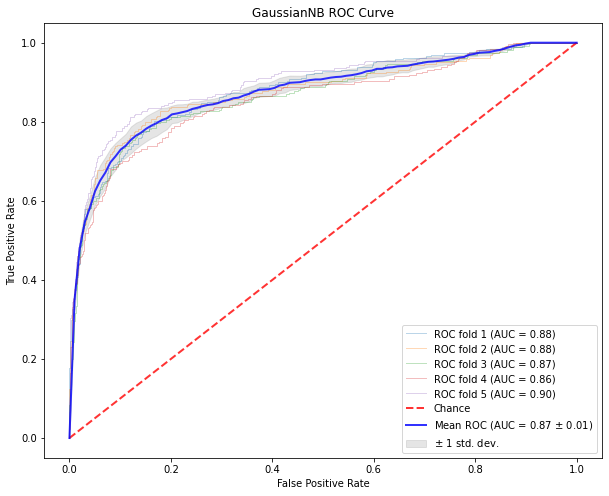

In [32]:
gnb = GaussianNB()

cv_gnb = train_cv(X_train, y_train, gnb, skf, None)

In [33]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
y_prob = pd.DataFrame(gnb.predict_proba(X_test))[1]

In [34]:
result.append(cv_score(y_test, y_pred, y_prob, 'Naïve Bayers'))

<b>Random Forest

In [35]:
# Hyperparameter Tuning

params = {"criterion":      ["gini", "entropy"],
          "max_depth":      np.arange(2, 6),
          "max_features":   np.arange(1, 20),
          "max_leaf_nodes": np.arange(6, 10),
         }

clf = RandomForestClassifier(random_state=42)
gridsearch = GridSearchCV(clf, param_grid=params, 
                          cv=5, scoring='f1_macro', return_train_score=True)

gridsearch.fit(X_train, y_train)

y_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred))
print(gridsearch.best_estimator_)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1701
           1       0.77      0.72      0.75       325

    accuracy                           0.92      2026
   macro avg       0.86      0.84      0.85      2026
weighted avg       0.92      0.92      0.92      2026

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features=19,
                       max_leaf_nodes=9, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)



Split 1
X_train shape: (6480, 35)
X_test shape: (1621, 35)

F1 Score  = 0.91
Accuracy   = 0.95
Kappa      = 0.82
Log Loss   = 1.56

Confusion Matrix:
        pred:0  pred:1
true:0    1347      13
true:1      60     201

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1360
           1       0.94      0.77      0.85       261

    accuracy                           0.95      1621
   macro avg       0.95      0.88      0.91      1621
weighted avg       0.95      0.95      0.95      1621


Split 2
X_train shape: (6481, 35)
X_test shape: (1620, 35)

F1 Score  = 0.90
Accuracy   = 0.95
Kappa      = 0.79
Log Loss   = 1.77

Confusion Matrix:
        pred:0  pred:1
true:0    1345      15
true:1      68     192

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1360
           1       0.93      0.74      0.82       260

    accuracy         

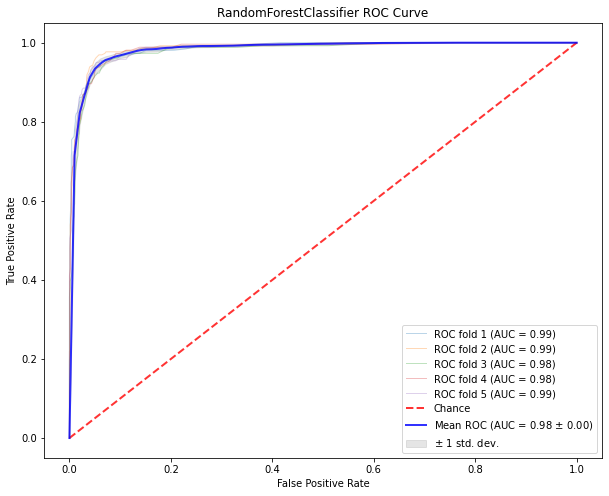

In [36]:
rf = RandomForestClassifier(max_depth=5, max_features=19,
                       max_leaf_nodes=9, random_state=42)
cv_rf = train_cv(X_train, y_train, rf, skf, None)

In [37]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = pd.DataFrame(rf.predict_proba(X_test))[1]

In [38]:
result.append(cv_score(y_test, y_pred, y_prob, 'Random Forest'))

<b>Gradient Boosting


Split 1
X_train shape: (6480, 35)
X_test shape: (1621, 35)

F1 Score  = 0.94
Accuracy   = 0.97
Kappa      = 0.88
Log Loss   = 1.11

Confusion Matrix:
        pred:0  pred:1
true:0    1346      14
true:1      38     223

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1360
           1       0.94      0.85      0.90       261

    accuracy                           0.97      1621
   macro avg       0.96      0.92      0.94      1621
weighted avg       0.97      0.97      0.97      1621


Split 2
X_train shape: (6481, 35)
X_test shape: (1620, 35)

F1 Score  = 0.93
Accuracy   = 0.97
Kappa      = 0.87
Log Loss   = 1.17

Confusion Matrix:
        pred:0  pred:1
true:0    1350      10
true:1      45     215

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1360
           1       0.96      0.83      0.89       260

    accuracy         

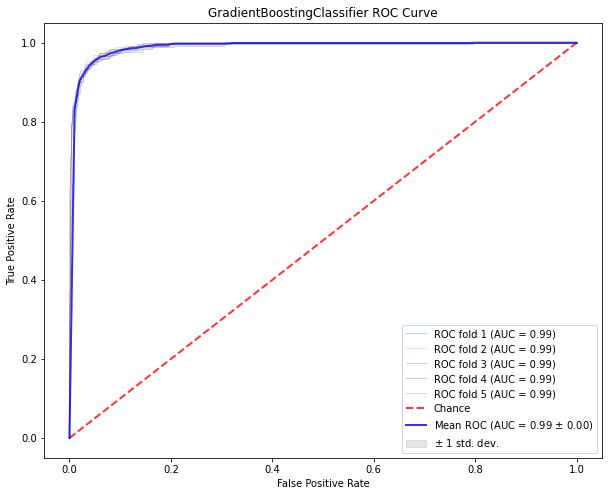

In [39]:
GBM = GradientBoostingClassifier(max_depth=5, max_features=19,
                            max_leaf_nodes=8, random_state=42)
cv_GBM = train_cv(X_train, y_train, GBM, skf, None)

In [40]:
GBM.fit(X_train, y_train)
y_pred = GBM.predict(X_test)
y_prob = pd.DataFrame(GBM.predict_proba(X_test))[1]

In [41]:
result.append(cv_score(y_test, y_pred, y_prob, 'Gradient Boosting'))

In [42]:
# result

pd.concat(result)

,Sprint,Neg,TN,FN,Pos,TP,FP,Accuracy,Recall,Precision,Recall 0,Precision 0,F1,F1 0,Macro F1,AUC
0,Linear Regression,1805,1646,159,221,166,55,0.894373,0.510769,0.751131,0.967666,0.911911,0.608059,0.938962,0.773510,0.900983
0,Decision Tree,1740,1632,108,286,217,69,0.912636,0.667692,0.758741,0.959436,0.937931,0.710311,0.948561,0.829436,0.918955
0,Naïve Bayers,1754,1626,128,272,197,75,0.899803,0.606154,0.724265,0.955908,0.927024,0.659966,0.941245,0.800606,0.877858
0,Random Forest,1757,1686,71,269,254,15,0.957552,0.781538,0.944238,0.991182,0.959590,0.855219,0.975130,0.915174,0.987027
0,Gradient Boosting,1727,1683,44,299,281,18,0.969398,0.864615,0.939799,0.989418,0.974522,0.900641,0.981914,0.941277,0.990787
